In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

In [2]:
purchase_df = pd.read_csv(r"C:\Users\Dell\Desktop\iGnosis Tech Internship\purchase_behaviour.csv")
transaction_df = pd.read_csv(r"C:\Users\Dell\Desktop\iGnosis Tech Internship\transaction_data.csv")


In [3]:
transaction_df.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [4]:
purchase_df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [5]:
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], errors='coerce')

print("Missing Values:\n", transaction_df.isnull().sum())
print("\nMissing Values in Purchase Data:\n", purchase_df.isnull().sum())

transaction_df.dropna(inplace=True)
purchase_df.dropna(inplace=True)

transaction_df.drop_duplicates(inplace=True)
purchase_df.drop_duplicates(inplace=True)

df = transaction_df.merge(purchase_df, on="LYLTY_CARD_NBR")

Missing Values:
 DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

Missing Values in Purchase Data:
 LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64


12. Dorito Corn Chp     Supreme 380g - Sales: 40352.00, Quantity Sold: 6509 units
87. Smiths Crnkle Chip  Orgnl Big Bag 380g - Sales: 36367.60, Quantity Sold: 6164 units
78. Smiths Crinkle Chips Salt & Vinegar 330g - Sales: 34804.20, Quantity Sold: 6106 units


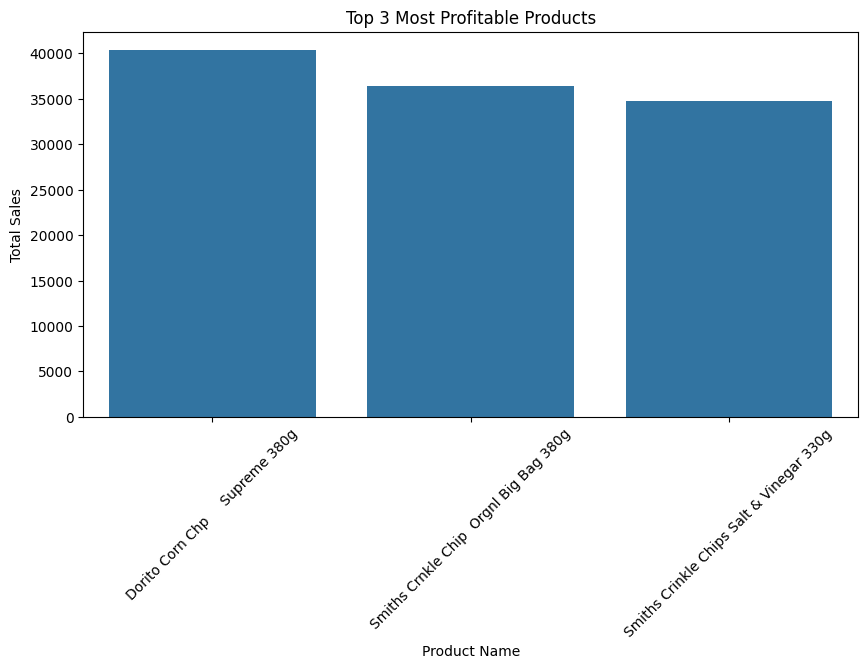

In [6]:

product_sales = df.groupby("PROD_NAME")[["TOT_SALES", "PROD_QTY"]].sum().reset_index()

top_products = product_sales.sort_values(by="TOT_SALES", ascending=False).head(3)

for idx, row in top_products.iterrows():
    print(f"{idx + 1}. {row['PROD_NAME']} - Sales: {row['TOT_SALES']:.2f}, Quantity Sold: {row['PROD_QTY']} units")

plt.figure(figsize=(10, 5))
sns.barplot(x="PROD_NAME", y="TOT_SALES", data=top_products)
plt.xticks(rotation=45)
plt.title("Top 3 Most Profitable Products")
plt.ylabel("Total Sales")
plt.xlabel("Product Name")
plt.show()


               LIFESTAGE PREMIUM_CUSTOMER  TOT_SALES
0         OLDER FAMILIES           Budget     395.80
1         OLDER FAMILIES       Mainstream     126.80
2         OLDER FAMILIES          Premium    1300.00
3  OLDER SINGLES/COUPLES       Mainstream     127.20
4         YOUNG FAMILIES           Budget     368.25
5         YOUNG FAMILIES          Premium     122.80


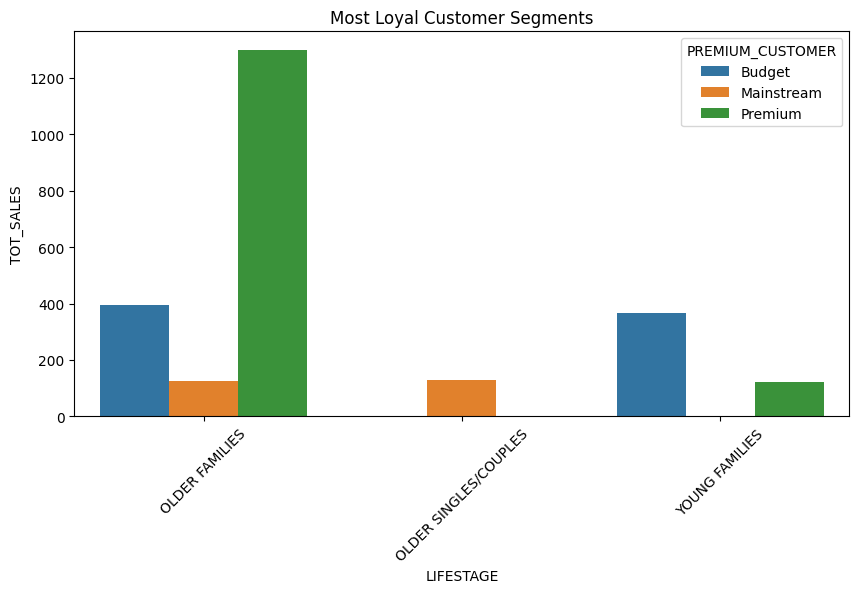

In [7]:
customer_loyalty = df.groupby(["LYLTY_CARD_NBR", "LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].sum().reset_index()
loyal_customers = customer_loyalty.sort_values(by="TOT_SALES", ascending=False).head(10)

loyal_segments = loyal_customers.groupby(["LIFESTAGE", "PREMIUM_CUSTOMER"])["TOT_SALES"].sum().reset_index()

print(loyal_segments)

plt.figure(figsize=(10, 5))
sns.barplot(x="LIFESTAGE", y="TOT_SALES", hue="PREMIUM_CUSTOMER", data=loyal_segments)
plt.xticks(rotation=45)
plt.title("Most Loyal Customer Segments")
plt.show()

In [8]:
loyal_customers = customer_loyalty.sort_values(by="TOT_SALES", ascending=False).head(10)

print("\nTop 10 Most Valuable Customers:")
print(loyal_customers)



Top 10 Most Valuable Customers:
       LYLTY_CARD_NBR              LIFESTAGE PREMIUM_CUSTOMER  TOT_SALES
59694          226000         OLDER FAMILIES          Premium    1300.00
60925          230078         OLDER FAMILIES           Budget     138.60
17292           63197         OLDER FAMILIES           Budget     132.80
69017          259009  OLDER SINGLES/COUPLES       Mainstream     127.20
42813          162039         OLDER FAMILIES       Mainstream     126.80
16001           58361         YOUNG FAMILIES           Budget     124.80
61001          230154         OLDER FAMILIES           Budget     124.40
25958           94185         YOUNG FAMILIES          Premium     122.80
35338          130090         YOUNG FAMILIES           Budget     122.65
47959          179228         YOUNG FAMILIES           Budget     120.80


In [9]:
encoder = LabelEncoder()
df["LIFESTAGE"] = encoder.fit_transform(df["LIFESTAGE"])
df["PREMIUM_CUSTOMER"] = encoder.fit_transform(df["PREMIUM_CUSTOMER"])

features = df.groupby("LYLTY_CARD_NBR").agg({
    "TOT_SALES": "sum",
    "PROD_QTY": "sum",
    "LIFESTAGE": "mean",
    "PREMIUM_CUSTOMER": "mean"
}).reset_index()


In [10]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features[["TOT_SALES", "PROD_QTY", "LIFESTAGE", "PREMIUM_CUSTOMER"]])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features["Cluster"] = kmeans.fit_predict(features_scaled)

cluster_summary = features.groupby("Cluster")[["TOT_SALES", "PROD_QTY"]].mean().sort_values(by="TOT_SALES")
cluster_names = {idx: name for idx, name in zip(cluster_summary.index, ["Low-Value Customers", "Mid-Value Customers", "High-Value Customers"])}
features["Cluster Name"] = features["Cluster"].map(cluster_names)

print(features.groupby("Cluster Name").mean())

                      LYLTY_CARD_NBR  TOT_SALES   PROD_QTY  LIFESTAGE  \
Cluster Name                                                            
High-Value Customers   134677.461977  51.721693  13.683744   3.337194   
Low-Value Customers    137485.554679  14.509106   3.707561   4.995239   
Mid-Value Customers    136062.607285  16.559556   4.246507   1.913718   

                      PREMIUM_CUSTOMER  Cluster  
Cluster Name                                     
High-Value Customers          0.855749      2.0  
Low-Value Customers           0.719001      0.0  
Mid-Value Customers           1.253992      1.0  


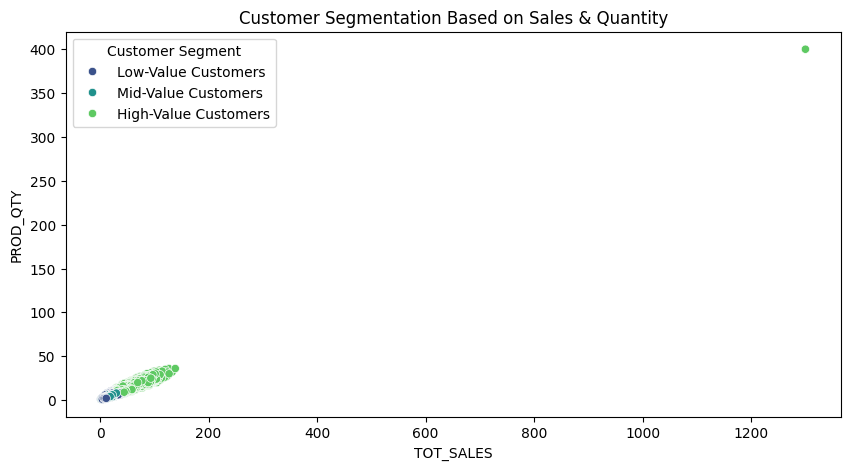

In [11]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=features["TOT_SALES"], y=features["PROD_QTY"], hue=features["Cluster Name"], palette="viridis")
plt.title("Customer Segmentation Based on Sales & Quantity")
plt.legend(title="Customer Segment")
plt.show()

In [12]:
from scipy.stats import zscore

features["Z_SCORE_SALES"] = zscore(features["TOT_SALES"])
features["Z_SCORE_QTY"] = zscore(features["PROD_QTY"])

outliers = features[(features["Z_SCORE_SALES"].abs() > 3) | (features["Z_SCORE_QTY"].abs() > 3)]

print(f"Detected {len(outliers)} outlier(s):")
print(outliers)


Detected 675 outlier(s):
       LYLTY_CARD_NBR  TOT_SALES  PROD_QTY  LIFESTAGE  PREMIUM_CUSTOMER  \
810              3153      116.4        26        0.0               2.0   
1097             4075       94.2        20        5.0               1.0   
1192             4170       91.6        18        0.0               2.0   
1247             4226       90.4        20        3.0               1.0   
1254             4233      107.2        24        2.0               1.0   
...               ...        ...       ...        ...               ...   
71997          270164       95.8        24        2.0               0.0   
72006          270173       92.8        21        5.0               0.0   
72022          270189       72.8        24        2.0               0.0   
72034          270201       89.2        26        3.0               0.0   
72295          271219       93.6        25        0.0               1.0   

       Cluster          Cluster Name  Z_SCORE_SALES  Z_SCORE_QTY  
810    

In [13]:
features_cleaned = features.loc[
    (features["Z_SCORE_SALES"].abs() <= 3) & (features["Z_SCORE_QTY"].abs() <= 3)
].copy()

features_cleaned.drop(columns=["Z_SCORE_SALES", "Z_SCORE_QTY"], inplace=True)


                      LYLTY_CARD_NBR  TOT_SALES   PROD_QTY  LIFESTAGE  \
Cluster Name                                                            
High-Value Customers   134582.817646  48.942113  12.900187   3.328877   
Low-Value Customers    137291.404104  13.937840   3.557782   5.127528   
Mid-Value Customers    136494.863308  15.142310   3.893242   1.766799   

                      PREMIUM_CUSTOMER  Cluster  
Cluster Name                                     
High-Value Customers          0.904007      1.0  
Low-Value Customers           0.918105      0.0  
Mid-Value Customers           0.956463      2.0  


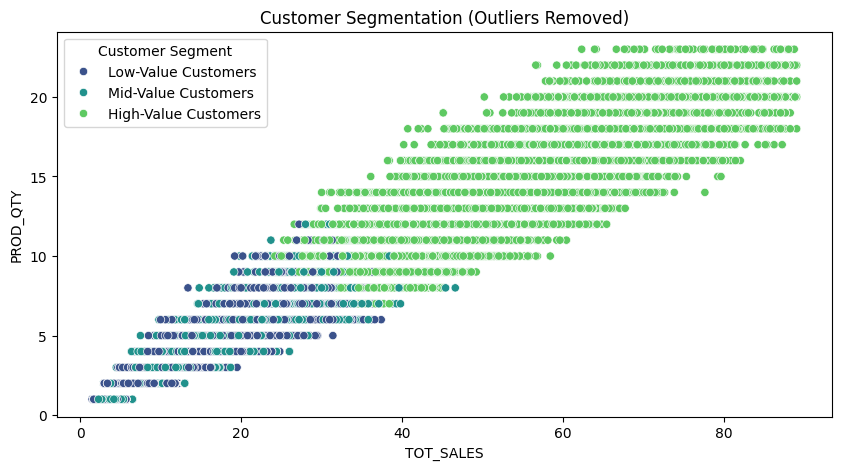

In [14]:
features_scaled_cleaned = scaler.fit_transform(features_cleaned[["TOT_SALES", "PROD_QTY", "LIFESTAGE", "PREMIUM_CUSTOMER"]])

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
features_cleaned["Cluster"] = kmeans.fit_predict(features_scaled_cleaned)

cluster_summary = features_cleaned.groupby("Cluster")[["TOT_SALES", "PROD_QTY"]].mean().sort_values(by="TOT_SALES")
cluster_names = {idx: name for idx, name in zip(cluster_summary.index, ["Low-Value Customers", "Mid-Value Customers", "High-Value Customers"])}
features_cleaned["Cluster Name"] = features_cleaned["Cluster"].map(cluster_names)

print(features_cleaned.groupby("Cluster Name").mean())

plt.figure(figsize=(10, 5))
sns.scatterplot(
    x=features_cleaned["TOT_SALES"],
    y=features_cleaned["PROD_QTY"],
    hue=features_cleaned["Cluster Name"],
    palette="viridis"
)
plt.title("Customer Segmentation (Outliers Removed)")
plt.legend(title="Customer Segment")
plt.show()
